# Module 4 - Metrics & Model Selection for "SecureBank" Fraud Detection System
by Jose Márquez Jaramillo

In [30]:
# import needed modules
import sys
import pandas as pd
import numpy as np
import re
from typing import Union, List, Dict, Tuple
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

sys.path.insert(0,'../')
from data_engineering import DataEngineering

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [31]:
# sklearn modules
# data transformation pipeline modules
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# machine learning and metric modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # To include SMOTE in the pipeline
from imblearn.under_sampling import RandomUnderSampler

## Task A: Summary of dataset and features
- Summarize your approach to the following to construct your dataset for training:
    - Sampling (See Module 3)
    - Feature selection (See Module 3)

(Context: To evaluate Task B and C, I'll need to know some background about how you construct your datasets.)

In [32]:
# Make sure to create a folder called data where to source the files. Otherwise call the files from your drive location

datasets = ["transactions_0.csv",
            "transactions_1.parquet",
            "transaction_2.json"]

datasets = [f'../data/{dataset}' for dataset in datasets]

In [33]:
data = DataEngineering(datasets)

## Removing unlabeled data and pre-processing the dataset
We will begin by:
1. removing any unlabeled data from the entire datateset
2. removing any duplicate transactions
3. standardizing dates
4. trim spaces
Then we will create a training and testing dataset.

In [34]:
# cleaning missing values
data.clean_missing_values([('is_fraud',None,'remove')])
# remove duplicate transactions
data.remove_duplicates(subset_by='trans_num')
# resolve anomalous dates
for col in ['trans_date_trans_time', 'dob']:
    data.standardize_dates(col)
# expand dates on transaction dates
data.expand_dates('trans_date_trans_time')
# trim spaces
for col in ['cc_num','merchant','category','first','last','sex','street','city','state','job']:
    data.trim_spaces(col)

## distance feature
The haversine_vectorized function calculates the great circle distance between two points on the Earth, given their latitudes and longitudes. This function employs the Haversine formula, which is essential for accurately determining the shortest path between points on a sphere, making it highly useful in fields like navigation and geographic information systems.

Using vectorized operations through NumPy, the function converts the input coordinates from decimal degrees to radians, then computes the distance by applying the Haversine formula. The calculation involves finding the angular distance in radians and multiplying it by the Earth's radius in miles to get the distance in miles.

This vectorized approach allows for efficient processing of large datasets by performing operations on entire arrays simultaneously, significantly enhancing performance over traditional loop-based methods. It also handles missing values by returning NaN for any pair of coordinates that includes missing data, ensuring reliable results even in incomplete datasets.

In [35]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth specified in decimal degrees using a vectorized Haversine formula.
    
    Parameters:
    - lat1, lon1, lat2, lon2 : Arrays of latitudes and longitudes (decimal degrees)
    
    Returns:
    - Array of distances between each pair of points in kilometers.
    """
    # Convert all latitudes and longitudes from decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of the Earth in kilometers
    r = 3956.0
    return c * r

# Apply the vectorized haversine function
data.dataset['distance_mi'] = haversine_vectorized(data.dataset['lat'], data.dataset['long'], 
                                         data.dataset['merch_lat'], data.dataset['merch_long'])
data.dataset['distance_mi'] = np.where((data.dataset['lat'].isna()) | (data.dataset['long'].isna()) | (data.dataset['merch_lat'].isna()) | (data.dataset['merch_long'].isna()),
None, data.dataset['distance_mi'])

# we will define age-groups based on generations, for more information please refer to
    # https://libguides.usc.edu/busdem/age
cond = [data.dataset['distance_mi'].isna(),
data.dataset['distance_mi']>=80,
data.dataset['distance_mi']>=40,
data.dataset['distance_mi']>=20,
data.dataset['distance_mi']<20]
groups = [None,
          '>80',
          '40-80',
          '20-40',
          '<20']
          
data.dataset['distance_cat'] = np.select(cond, groups)

## Age Features
From the date of birth in the dataset we will compute two features:
1. Age in years of the client
2. Classify the client in the different age-groups based on our exploratory analysis. The analysis showed that some age-groups are more prone to be victims of fraudulent transactions.

In [36]:
data.dataset['age_years'] = np.where(data.dataset['dob'].isna(),
                                     None,
                                     (pd.Timestamp.today() - data.dataset['dob'])  / pd.Timedelta(365, 'D')
                                    )

data.dataset['yob'] = data.dataset['dob'].dt.year

# we will define age-groups based on generations, for more information please refer to
    # https://libguides.usc.edu/busdem/age
cond = [data.dataset['yob']>=2013,
        data.dataset['yob']>=1995,
        data.dataset['yob']>=1980,
        data.dataset['yob']>=1965,
        data.dataset['yob']>=1946,
        data.dataset['yob']>=1925,
        data.dataset['yob']>=1901,
        data.dataset['yob'].isna()]
groups = ['Alpha',
          'Z',
          'Millennial',
          'X',
          'Baby Boomer',
          'Silent',
          'Greatest',
          None]
data.dataset['age_group'] = np.select(cond, groups)

## Split a Training/Validation and Testing Dataset
The code below provides a method for dividing a dataset into training, validation, and testing sets using the `StratifiedShuffleSplit` from `scikit-learn`. This approach ensures that each subset of the dataset maintains the same percentage of samples of each class as the complete set. Here's a detailed explanation of each step and the benefits of this approach

### Explanation of the Code
1. Initial Split into Training and Testing Sets:
    - StratifiedShuffleSplit is initialized with n_splits=1 and test_size=0.2. This means it will make one split (one pair of train and test sets), and the test set will comprise 20% of the data.
    - random_state=42 ensures reproducibility of the split.
    - The split is stratified by the is_fraud column, maintaining the proportion of fraudulent to non-fraudulent transactions consistent across the training and testing datasets.
    - Data is accessed via .loc[] using the indices for training and test sets. reset_index(drop=True) is used to reset the index in each subset, which helps with data handling by avoiding issues with non-sequential indices.
    
2. Further Splitting the Training Data into New Training and Validation Sets:
    - A second `StratifiedShuffleSplit` is used to split the previous training data further, this time separating out 10% of it as validation data.
    - This split also uses stratification to ensure the class distribution is maintained.
    
### Justification for Using StratifiedShuffleSplit
- Class Distribution Consistency: Especially important in datasets where the class distribution is imbalanced (e.g., fraud detection where fraudulent transactions are a small fraction of the total). Stratification ensures that each split has a proportionate number of samples from each class, which prevents training or testing on unrepresentative data subsets.
- Random Shuffling: This introduces randomness in the selection of data points for training and testing, which helps in building models that generalize better. It prevents the model from learning any accidental patterns that may arise from the order of the data.
- Multiple Splits: Initially separating data into training and testing, and then further splitting the training set into new training and validation subsets, allows for a more robust evaluation setup. The model is trained on the training set, tuned using the validation set, and finally evaluated on the test set that it has never seen before, which gives a better estimate of real-world performance.

In [37]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(data.dataset, data.dataset['is_fraud']):
    train_data = data.dataset.loc[train_index].reset_index(drop=True)
    test_data = data.dataset.loc[test_index].reset_index(drop=True)
print(f"The Training Dataset Contains {train_data.shape}")
print(train_data['is_fraud'].value_counts() / train_data['is_fraud'].count())
print()
print(f"The Testing Dataset Contains {test_data.shape}")
print(test_data['is_fraud'].value_counts() / test_data['is_fraud'].count())

The Training Dataset Contains (800924, 32)
is_fraud
0.0    0.994263
1.0    0.005737
Name: count, dtype: float64

The Testing Dataset Contains (200231, 32)
is_fraud
0.0    0.994262
1.0    0.005738
Name: count, dtype: float64


In [38]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in split.split(train_data, train_data['is_fraud']):
    train_data_ = train_data.loc[train_index]
    valid_data = train_data.loc[test_index]

## Create a Data Pipeline

A data pipeline is helpful to transform different datasets in a machine learning system while ingesting data. We will crease a function that provides the following benefits:
1. Robust Data Handling:the function incorporates data imputation and scaling which are crucial steps in preprocessing to deal with real-world data inconsistencies and to standardize input scales for algorithms that are sensitive to feature magnitude.
2. Categorical Data Encoding: One-hot encoding transforms categorical data into a binary matrix, necessary for many machine learning algorithms that require numerical input.
3. Automated Pipeline: Using a pipeline for preprocessing automates the steps and reduces the chance of errors like data leakage. It ensures that the same operations are applied during both training and prediction, improving the model's performance and reliability.
4. Target Encoding: Converting the target variable into a one-hot format is particularly useful for classification problems where the algorithm expects target data in this format.

The pre_process function provided below is designed to prepare a dataset for machine learning, specifically for models that require numerical inputs such as those used in fraud detection. Here’s a breakdown of what the function does and why it is structured the way it is:
### `pre_process()` Function Breakdown
1. Separate Features and Target Variable: The function separates the features (x) and the target (y). The features exclude the 'is-fraud' column, which seems to be a typo or mismatch since the target variable is captured using 'is_fraud'.
2. Identify Numerical and Categorical Attributes: Attributes are categorized into numerical and categorical types, facilitating different preprocessing techniques for each type.
3. Numerical and Categorical Pipelines:
    - Numerical Pipeline: The numerical pipeline handles missing values by replacing them with the median (which is less sensitive to outliers than the mean) and scales the data to standardize its range.
    - Categorical Pipeline: The categorical pipeline replaces missing values with the most frequent category and applies one-hot encoding to transform categorical variables into a format that can be provided to machine learning models.
4. Combine Pipelines in a Column Transformer: This combines both pipelines and applies them to the appropriate columns in the dataset, ensuring that each type of data is processed correctly.
5. Process Target Variable: This section of the code converts the target variable y into a one-hot encoded format. It identifies unique categories in y, assigns a unique index to each category, and creates a one-hot encoded matrix where each row corresponds to a sample and each column corresponds to a category.
6. Return Transformed Features and Targets: Returns the preprocessed features, the original target variable, and the one-hot encoded target. This allows for flexibility depending on whether the model expects a one-hot encoded output or the original categorical labels.

In [39]:
def pre_process(dataset, smote_sampling=False):
    """
    Preprocesses the given dataset for fraud detection modeling.
    
    This function handles numerical and categorical data preprocessing and can optionally
    apply SMOTE for handling class imbalance in training datasets.
    
    Parameters:
        dataset (DataFrame): The input dataset containing features and a target labeled 'is_fraud'.
        use_smote (bool): Flag to determine whether to apply SMOTE for oversampling the minority class.

    Returns:
        Tuple (np.ndarray, pd.Series, np.ndarray):
            - Processed features after scaling and encoding.
            - Resampled target variable if SMOTE is used.
            - One-hot encoded target variable.
    """
    # Separating features and target variable
    x = dataset[[col for col in dataset.columns if col != 'is_fraud']]
    y = dataset['is_fraud']
    
    # Defining attributes for different data processing methods
    num_attributes = ['amt',
                       'age_years',
                         'distance_mi']  # Numeric features
    cat_attributes = ['distance_cat',
                      #'sex',
                      'age_group',
                      'category',
                      'trans_date_trans_time_weekend',
                      #'trans_date_trans_time_day_of_week',
                      'trans_date_trans_time_time_of_day',
                      #'trans_date_trans_time_month'
                      ]

    cat_values = [['40-80', '<20', '20-40', '>80',None],
                #[None, 'F', 'M'],
                ['Millennial', None, 'Silent', 'Baby Boomer', 'X', 'Z', 'Greatest'],
                ['MISC_NET',  'GROCERY_POS',  'ENTERTAINMENT',  'GAS_TRANSPORT',  'MISC_POS',  'GROCERY_NET',  None,  'SHOPPING_POS',
                'SHOPPING_NET',  'FOOD_DINING',  'PERSONAL_CARE',  'HEALTH_FITNESS',  'TRAVEL',  'KIDS_PETS',  'HOME'],
                [True, False],
                #[1, 2, 3, 4, 5, 6, 0], 
                ['Late Evening',  'Early Morning',  'Morning',  'Afternoon',  'Late Afternoon',  'Evening'],
                #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
                ]

    names = [[str(cat_attributes[i])+'_'+str(cat_values[i][j]) for j in range(len(cat_values[i]))] for i, cat in enumerate(cat_attributes)]
    feature_names = num_attributes.copy()
    for name in names:
        feature_names.extend(name)  

    std_scaler =  StandardScaler()
    # Based on the training Data implement values for scaling
    std_scaler.mean_ = [70.306486,50.794746,47.254624]
    std_scaler.scale_ = [159.053100,17.412408,18.072797]

    # Creating pipelines for numeric and categorical feature processing
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Imputing missing values with median
        ('std_scaler', std_scaler)                # Standardizing features
    ])

    cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputing missing values with mode
    ('one_hot', OneHotEncoder(categories=cat_values))                           # Applying one-hot encoding
        ])
    
    # Combining numeric and categorical pipelines into a column transformer
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
        ("cat", cat_pipeline, cat_attributes)
    ])

    # Optional SMOTE inclusion based on use_smote flag
    if smote_sampling:
        # Include SMOTE in the pipeline if use_smote is True
        pipeline = ImbPipeline([
            ('preprocessor', full_pipeline),
            ('smote_over', SMOTE(random_state=42, sampling_strategy=0.05)),
            ('random_under', RandomUnderSampler(sampling_strategy=0.1))  # SMOTE for oversampling
        ])
    else:
        # Regular pipeline without SMOTE
        pipeline = Pipeline([
            ('preprocessor', full_pipeline)
        ])
    
    # Applying the pipeline to process features and optionally apply SMOTE
    if smote_sampling:
        x_processed, y_resampled = pipeline.fit_resample(x, y)
    else:
        x_processed = pipeline.fit_transform(x)
        y_resampled = y

    return x_processed, y_resampled, feature_names

In [40]:
x_train, y_train, feature_names = pre_process(train_data_, smote_sampling=True)
x_valid, y_valid, feature_names = pre_process(valid_data, smote_sampling=True)
x_test, y_test, feature_names = pre_process(test_data)

for y_sample in [y_train, y_valid, y_test]:
    print(y_sample.value_counts()/y_sample.count())
    print()

is_fraud
0.0    0.909091
1.0    0.090909
Name: count, dtype: float64

is_fraud
0.0    0.909091
1.0    0.090909
Name: count, dtype: float64

is_fraud
0.0    0.994262
1.0    0.005738
Name: count, dtype: float64



## Offline Training Metric
The **Area Under the Precision-Recall Curve (AUPRC)** is an important offline metric to evaluate the model's predictions during the development phase, especially suitable in fraud detection where the dataset is typically imbalanced. AUPRC is a comprehensive measure that assesses a model's accuracy in predicting fraudulent transactions and its ability to maintain low false positives—key to operational efficiency and customer trust. The strategy for analyzing this metric includes evaluating different models or iterations to identify which best balances precision and recall, both relevant for a practical fraud detection system. Moreover, varying the decision threshold for classifying a transaction as fraudulent provides insights into how precision and recall trade off against each other, helping to select a better threshold that maximizes both. Analyzing feature importance through changes in AUPRC can further guide feature engineering efforts by identifying which features most significantly impact fraud detection accuracy. While AUPRC is advantageous in handling class imbalance and helping fine-tune classification thresholds, it does not provide insights into the error distribution across different transaction types or customer segments and might be insensitive to changes in the less prevalent class if the dataset is extremely imbalanced. This comprehensive approach ensures a thorough understanding and evaluation of the model's predictive capabilities, vital for deploying an effective fraud detection system.
The same MIT research also emphasized the effectiveness of using features extracted from transaction data to improve the precision and recall of fraud detection models. Their method involved creating a model to identify indicators of fraud by analyzing extensive transaction details, which not only reduced false positives but also enhanced the overall performance of their fraud detection system. This indicates that AUPRC can be a good metric for evaluating models in an imbalanced class scenario like fraud detection, where the focus is on identifying the minority class (fraudulent transactions) accurately​ ([MIT News](https://news.mit.edu/2018/machine-learning-financial-credit-card-fraud-0920))​.

The average precision score calculated by scikit-learn can be used as an estimate for the AUPRC ([Stack Overflow](https://stackoverflow.com/questions/68567722/how-to-use-precision-recall-curve-in-gridsearchcv),[Sinyi-Chou](https://sinyi-chou.github.io/python-sklearn-precision-recall/))

In [41]:
score = 'average_precision'

## Hyper-parameter Tuning
In the following section of the code I utilize the GridSearchCV from the scikit-learn library to perform hyperparameter tuning for three different machine learning models: Logistic Regression, Support Vector Classifier (SVC), and Random Forest Classifier. Each model is configured with a distinct set of hyperparameters, and the goal is to find the best combination based on a given scoring method.

### Logistic Regression Tuning
- fit_intercept: Whether to calculate the intercept for this model or not. The intercept is a bias term in the decision boundary equation. Choosing between True or False allows testing model performance with or without bias.
- solver: Algorithm to use in the optimization problem. Options are 'liblinear' and 'newton-cg':
    - 'liblinear' is good for small datasets and binary classification.
    - 'newton-cg' handles multinomial loss and supports more classes.
- **Choice Justification**: These options allow exploration of model behaviors under different optimization algorithms and model configurations (bias term presence), which can significantly impact performance depending on the nature of the data.

In [42]:
parameters = {'fit_intercept':(True, False),
               'solver':('liblinear', 'newton-cg')}
log = LogisticRegression(random_state=0)
clf_log = GridSearchCV(log, parameters, scoring=score)
clf_log.fit(x_valid, y_valid)
log_params = clf_log.best_params_
print('Best Score:',clf_log.score(x_valid,y_valid))
print(log_params)

Best Score: 0.7614369099334297
{'fit_intercept': True, 'solver': 'newton-cg'}


### Random Forrest Classifier Tunning
- Hyperparameters:
    - n_estimators: Number of trees in the forest. More trees can lead to better performance but increase computational cost.
    - criterion: The function to measure the quality of a split ('gini' for the Gini impurity and 'entropy' for the information gain).
    - max_depth: The maximum depth of each tree. Limited depth can prevent overfitting; None allows unrestricted growth of the decision tree.
- **Choice Justification**: This configuration tests various complexities and strengths of the ensemble method, assessing both shallow and deep forests, with varying numbers of trees and split criteria, to balance between overfitting and underfitting.

In [43]:
parameters = {'n_estimators':[10,20,30,50],
               'criterion': ["gini", "entropy"],
                 'max_depth':[10,20,50,100]}
rf = RandomForestClassifier(random_state=0)
clf_rf = GridSearchCV(rf, parameters, scoring=score)
clf_rf.fit(x_valid, y_valid)
rf_params = clf_rf.best_params_
print('Best Score:',clf_rf.score(x_valid,y_valid))
print('Best Parameters:', rf_params)

Best Score: 0.9993872854071251
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 50}


### Support Vector Machine Classifier Tunning
- Hyperparameters:
    - kernel: The type of hyperplane used to separate the data. 'linear' for linear hyperplane and 'rbf' for non-linear.
    - C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. Lower values specify stronger regularization.
- **Choice Justification**: This selection covers both linear and non-linear decision boundaries, and varying degrees of regularization, to evaluate which configuration best generalizes the underlying patterns in the data.

In [44]:
parameters = {'kernel':['linear', 'rbf'],
              'C':[0.1, 1, 10, 50, 100]}
svc = SVC(random_state=0)
clf_svc = GridSearchCV(svc, parameters, scoring=score)
clf_svc.fit(x_valid, y_valid)
svc_params = clf_svc.best_params_
print('Best Score:',clf_svc.score(x_valid,y_valid))
print('Best Parameters:', svc_params)

Best Score: 0.9943331572028321
Best Parameters: {'C': 100, 'kernel': 'rbf'}


## Training the Models using the tuned hyper-parameters
Considering the tuned hyper-parameters, now train the models using the full training data. 

In [45]:
log_tuned = LogisticRegression(random_state=0, **log_params)
log_tuned.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [46]:
rc_tuned = RandomForestClassifier(random_state=0, **rf_params)
rc_tuned.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=50, random_state=0)

In [47]:
svc_tuned = SVC(random_state=0, **svc_params)
svc_tuned.fit(x_train, y_train)

SVC(C=100, random_state=0)

## Comparing the Models
A Precision-Recall curve (PR curve) and its associated Area Under the Curve (AUPRC) provide valuable insights into the performance of classification models, especially when dealing with imbalanced datasets. Here’s why these curves are particularly useful and why comparing them across models can be beneficial:

### Reasons to Use Precision-Recall Curves
1. Focus on Minority Class: In imbalanced datasets where the positive class (e.g., "fraudulent transactions") is much less frequent than the negative class, the PR curve is more informative than other metrics like the ROC curve. This is because the PR curve specifically focuses on the performance of the classifier in identifying the positive class, which is often of greater interest.

2. Precision and Recall Trade-off:

    - Precision measures the accuracy of the positive predictions. It is the proportion of true positives among all instances classified as positive. High precision indicates a low false positive rate.
    - Recall (or sensitivity) measures the ability of the classifier to find all the positive samples. It is the proportion of true positives that have been identified over the total number of actual positives.
    - The PR curve shows the trade-off between precision and recall for different threshold values. This helps in understanding how changes in the model’s threshold can impact its ability to correctly predict the positive class while avoiding false positives.
    - Model Selection for Specific Objectives: Depending on the application, one might prefer to maximize either recall or precision (e.g., in medical testing, high recall might be preferred to ensure all positive cases are identified, even at the expense of higher false positives). The PR curve helps in selecting the appropriate threshold to achieve the desired balance between precision and recall.

### Reasons to Compare PR Curves Across Models
1. Model Performance Benchmarking: By plotting PR curves for different models on the same graph, you can visually compare which model achieves higher precision at equivalent levels of recall or vice versa. This is especially helpful when no single model is the best across all thresholds.

2. Identify Overfitting: By comparing the PR curves for training and testing datasets, as suggested in the enhanced function, one can identify if a model performs exceptionally well on the training data but poorly on the testing data—a classic sign of overfitting.

3. Optimize Model Selection: Different models might have different strengths depending on the specific characteristics of the data. For instance, while logistic regression might perform better in scenarios with linear decision boundaries, tree-based models like random forests could be better at capturing nonlinear relationships. Comparing PR curves helps in selecting the model that best captures the underlying patterns in the data for the specific task.

4. Cost-effective Decision Making: In many business or medical applications, the cost of false positives (precision) and false negatives (recall) can vary greatly. PR curves enable stakeholders to analyze the potential trade-offs and select models that minimize costs or maximize effectiveness according to their specific needs.

Overall, PR curves and AUPRC are powerful tools for evaluating and comparing the performance of different classifiers on tasks with imbalanced datasets. They provide a nuanced view of model effectiveness that is crucial for making informed decisions in precision-critical applications.

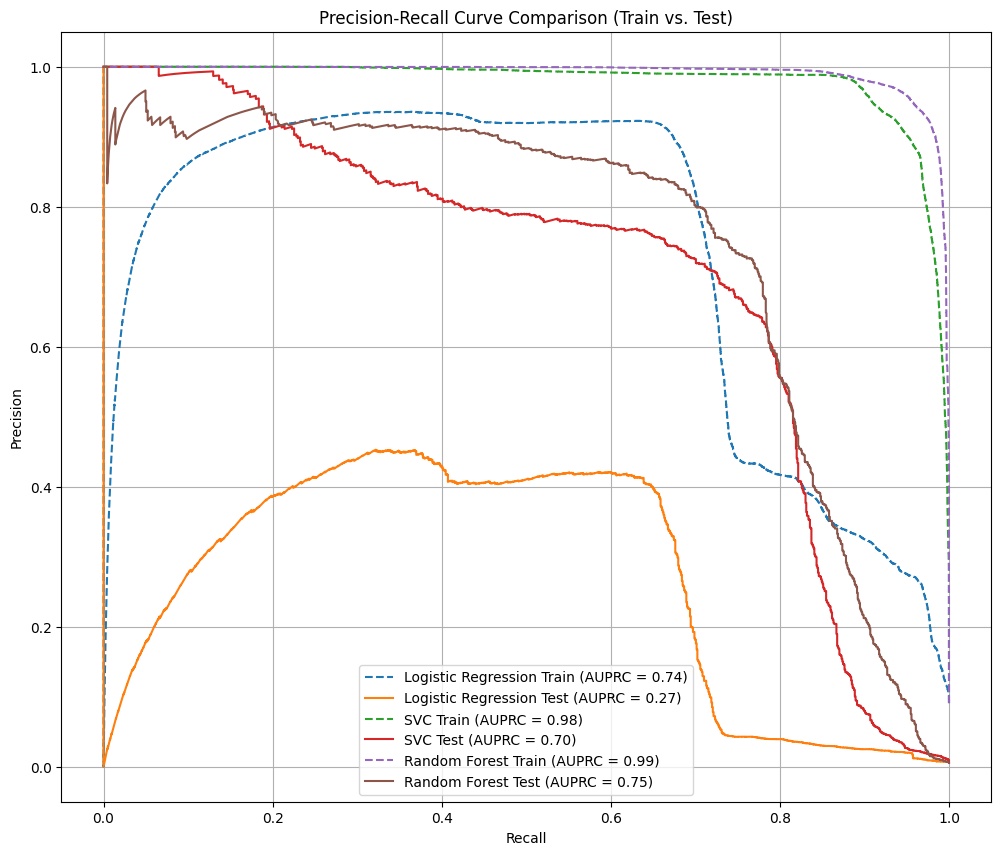

In [48]:
def plot_auprc_train_test(models, model_names, x_train, y_train, x_test, y_test):
    """
    Plot the AUPRC for multiple models on both training and testing datasets.

    Args:
    - models (list): List of trained model objects.
    - model_names (list): List of model names as strings.
    - x_train (DataFrame or array): Training features.
    - y_train (array): True binary labels for training data.
    - x_test (DataFrame or array): Testing features.
    - y_test (array): True binary labels for testing data.
    """
    plt.figure(figsize=(12, 10))

    for model, name in zip(models, model_names):
        # Predict scores for both training and testing data
        if hasattr(model, "decision_function"):  # For SVC
            y_scores_train = model.decision_function(x_train)
            y_scores_test = model.decision_function(x_test)
        else:  # For Logistic Regression and Random Forest
            y_scores_train = model.predict_proba(x_train)[:, 1]
            y_scores_test = model.predict_proba(x_test)[:, 1]

        # Compute Precision-Recall curve and AUC for training data
        precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
        pr_auc_train = auc(recall_train, precision_train)

        # Compute Precision-Recall curve and AUC for testing data
        precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)
        pr_auc_test = auc(recall_test, precision_test)

        # Plot the Precision-Recall curves for the training and testing data
        plt.plot(recall_train, precision_train, linestyle='--', label=f'{name} Train (AUPRC = {pr_auc_train:.2f})')
        plt.plot(recall_test, precision_test, label=f'{name} Test (AUPRC = {pr_auc_test:.2f})')

    plt.title('Precision-Recall Curve Comparison (Train vs. Test)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Usage:
models = [log_tuned, svc_tuned, rc_tuned]
model_names = ['Logistic Regression', 'SVC', 'Random Forest']
plot_auprc_train_test(models, model_names, x_train, y_train, x_test, y_test)

## Interpretation of AUPRC
Based on the image of Precision-Recall curves for the three models on both the training and testing datasets, we can analyze the models as follow.
### Logistic Regression
- **Training**: AUPRC = 0.74 indicates good performance on the balanced training data.
- **Testing**: AUPRC = 0.27 highlights a severe drop in performance, suggesting that logistic regression may have over-learned the artificial patterns created by SMOTE and under-sampling, failing to generalize well to the original data distribution.
    
### Support Vector Classifier
- **Training**: AUPRC = 0.98 shows excellent performance on the training set.
- **Testing**: AUPRC = 0.70, while better than logistic regression, still indicates a significant performance drop. The model may be sensitive to the synthetic nature of the training data but maintains a decent level of generalization compared to logistic regression.
    
### Random Forest
- **Training**: AUPRC = 0.99 suggests near-perfect performance on the balanced training set.
- **Testing**: AUPRC = 0.75, although the highest among the test results, also shows overfitting. However, Random Forest appears to be more robust against the artificial noise introduced by SMOTE and under-sampling, possibly due to its ensemble nature, which inherently provides a level of regularization.
    
### Model Selection
#### Performance Comparison
- **Random Forest** shows the highest AUPRC scores for both training and testing datasets. This consistency suggests it's robust, especially in handling synthetic data and still provides good predictive power on the test dataset. It demonstrates a capacity to distinguish between classes effectively.
- **Logistic Regression** demonstrates a stark contrast in performance between training and testing, with a significant drop in AUPRC from 0.74 in training to 0.26 in testing. This major drop suggests that the model has learned specific patterns from the balanced training data that do not generalize well to the test data.
- **SVC** has decent performance in the training set (AUPRC = 0.98) but experiences a drop in the test set (AUPRC = 0.70). This indicates that while SVC can effectively learn from the synthetic minority samples, it struggles to generalize these findings to new, real-world data.
#### Overfitting Assessment
- **Random Forest** demonstrates the best generalization among the three, despite a performance decrease from training to testing. The drop in AUPRC (from 0.99 to 0.72) is noticeable but less severe compared to the other models, indicating that it overfits less despite the high complexity typical of tree-based models.
- **Logistic Regression** shows severe overfitting, evidenced by the drastic decrease in AUPRC. It might have under-learned, or the simpler decision boundaries typical of logistic regression may not capture complex patterns adequately after synthetic oversampling.
- **SVC** has a significant performance reduction from training to testing, indicative of overfitting. The model may be too sensitive to the noise and synthetic data points generated by SMOTE.

### Conclusions
- **Random Forest** is the best choice, not only for its high performance on the test set but also for its relatively better handling of overfitting compared to SVC and Logistic Regression. Its ability to manage complex patterns and maintain generalization makes it suitable for critical tasks like fraud detection.

- **Logistic Regression** might be considered for very specific use cases where interpretability is paramount, and the consequences of lower detection rates are acceptable. However, strategies to improve its resistance to overfitting and increase its robustness should be explored, such as regularization or using a different feature set.

- **SVC**, while capable in training, doesn't translate its learning effectively to new, real-world scenarios, making it less favorable for this dataset. Consider parameter tuning or exploring different kernel settings to potentially enhance its performance and generalization.

In conclusion, the Random Forest model is recommended due to its superior ability to handle imbalanced data processed through SMOTE and under-sampling, along with a strong performance in real-world scenarios. This analysis emphasizes the importance of using complex, ensemble methods in scenarios where the training data is heavily manipulated to address class imbalances.

## Evaluating the Random Forest Model

In [51]:
# Predictions
y_pred_train = rc_tuned.predict(x_train)
y_pred_test = rc_tuned.predict(x_test)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Classification Report
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Convert classification reports to DataFrames
df_report_train = pd.DataFrame(report_train).transpose()
df_report_test = pd.DataFrame(report_test).transpose()

# Display the metrics in a consolidated table
metrics_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support'],
    'Train (Class 0)': [report_train['0.0']['precision'], report_train['0.0']['recall'], report_train['0.0']['f1-score'], report_train['0.0']['support']],
    'Train (Class 1)': [report_train['1.0']['precision'], report_train['1.0']['recall'], report_train['1.0']['f1-score'], report_train['1.0']['support']],
    'Test (Class 0)': [report_test['0.0']['precision'], report_test['0.0']['recall'], report_test['0.0']['f1-score'], report_test['0.0']['support']],
    'Test (Class 1)': [report_test['1.0']['precision'], report_test['1.0']['recall'], report_test['1.0']['f1-score'], report_test['1.0']['support']]
})

print("Confusion Matrix - Training Data")
print(conf_matrix_train)
print("\nConfusion Matrix - Testing Data")
print(conf_matrix_test)
print("\nClassification Report - Training Data")
print(df_report_train)
print("\nClassification Report - Testing Data")
print(df_report_test)
print("\nMetrics Table")
print(metrics_table)

Confusion Matrix - Training Data
[[357762    578]
 [  3794  32040]]

Confusion Matrix - Testing Data
[[198611    471]
 [   249    900]]

Classification Report - Training Data
              precision    recall  f1-score        support
0.0            0.989506  0.998387  0.993927  358340.000000
1.0            0.982280  0.894123  0.936130   35834.000000
accuracy       0.988908  0.988908  0.988908       0.988908
macro avg      0.985893  0.946255  0.965029  394174.000000
weighted avg   0.988849  0.988908  0.988673  394174.000000

Classification Report - Testing Data
              precision    recall  f1-score        support
0.0            0.998748  0.997634  0.998191  199082.000000
1.0            0.656455  0.783290  0.714286    1149.000000
accuracy       0.996404  0.996404  0.996404       0.996404
macro avg      0.827602  0.890462  0.856238  200231.000000
weighted avg   0.996784  0.996404  0.996562  200231.000000

Metrics Table
      Metric  Train (Class 0)  Train (Class 1)  Test (Class 0)  

### Performance Summary
#### Training Data Performance
- **Confusion Matrix**: The model identified nearly all negative class (0) samples correctly (357,817 out of 358,340), with only 523 false positives. For the positive class (1), it correctly identified 31,825 out of 35,834 samples, with 4,009 false negatives.
- **Precision and Recall**: The model showed high precision (98.38%) and recall (88.81%) for the positive class, indicating strong performance in identifying positive cases without many false positives.
- **F1-Score**: The F1-score, which balances precision and recall, is quite high for both classes, especially class 0 at 99.37%. For class 1, it is 93.35%, reflecting the slightly lower recall relative to precision.
#### Testing Data Performance
- **Confusion Matrix**: On the testing dataset, the model again performed exceptionally well for the negative class (0), correctly predicting 198,570 out of 199,082 samples, with only 512 false positives. For the positive class (1), it correctly identified 886 out of 1,149 samples, with 263 false negatives.
- **Precision and Recall**: There is a notable difference in precision for the positive class between training (98.38%) and testing (63.38%), which could indicate some overfitting to the training data or differences in data distribution. However, recall for the positive class in testing (77.11%) is commendably high.
- **F1-Score**: The F1-score in testing for class 1 (69.57%) shows a decline compared to the training data, which aligns with the lower precision noted.
### General Analysis
- **Class Imbalance Handling**: The model has effectively handled the class imbalance, as evident from the high recall rates in both datasets. However, there's a slight performance dip in precision for the positive class in the testing set, suggesting some challenges in generalizing the positive class predictions without introducing more false positives.
- **Overfitting Assessment**: The model shows excellent results on the training data but a drop in precision for the positive class on the testing data. This indicates some level of overfitting, where the model may be too closely fitted to the characteristics of the training data, particularly the synthetic examples possibly introduced by SMOTE.
- **Overall Effectiveness**: Despite the slight issues with precision in the testing data, the Random Forest model demonstrates high overall accuracy (99.61% in testing), making it very effective for practical use, especially in scenarios like fraud detection where missing a true fraud case (high recall) can be more critical than incorrectly flagging a legitimate transaction (lower precision).

In [50]:
filename = '../models/suport_vector_classifier.sav'
pickle.dump(svc_tuned, open(filename, 'wb'))
filename = '../models/random_forest_classifier.sav'
pickle.dump(rc_tuned, open(filename, 'wb'))
filename = '../models/logistic_regression_classifier.sav'
pickle.dump(log_tuned, open(filename, 'wb'))